# Simple stochastic gradients optimisation demo

This notebook allows us to run the different stochastic optimisation algorithms in *revrand* on a simple dataset.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
pl.style.use('ggplot')
from scipy.optimize import minimize
from revrand.optimize import sgd, AdaDelta, Adam
from revrand import basis_functions as bf
from revrand.metrics import smse


### Settings

In [2]:
# Settings

batch_size = 10
var = 0.05
nPoints = 1000
nQueries = 500
maxiter = 5000

updater = Adam(alpha=0.01, epsilon=1e-6, beta1=0.9, beta2=0.99)
# updater = AdaDelta(rho=0.1, epsilon=1e-5)
    

### Objective function

In [3]:
def f(w, Data, sigma=1.0):

    y, Phi = Data[:, 0], Data[:, 1:]

    logp = -1. / (2 * sigma**2) * ((y - Phi.dot(w))**2).sum()
    d = 1. / (sigma**2) * Phi.T.dot((y - Phi.dot(w)))

    return -logp, -d


### Create Dataset

In [4]:
# Create dataset
X = np.linspace(0.0, 1.0, nPoints)[:, np.newaxis]
Y = np.sin(2 * np.pi * X.flatten()) + np.random.randn(nPoints) * var
centres = np.linspace(0.0, 1.0, 20)[:, np.newaxis]
Phi = bf.RadialBasis(centres).transform(X, 0.3)
train_dat = np.hstack((Y[:, np.newaxis], Phi))

Xs = np.linspace(0.0, 1.0, nQueries)[:, np.newaxis]
Yt = np.sin(2 * np.pi * Xs.flatten())
Phi_s = bf.RadialBasis(centres).transform(Xs, 0.3)


### Analytic Solution


In [5]:
w = np.linalg.solve(Phi.T.dot(Phi), Phi.T.dot(Y))
Ys = Phi_s.dot(w)


### Optimiser Solution

In [6]:
w0 = np.random.randn(Phi.shape[1])
results = minimize(f, w0, args=(train_dat,), jac=True, method='L-BFGS-B')
w_grad = results['x']
Ys_grad = Phi_s.dot(w_grad)
    

### Stochastic Gradients Solution


In [7]:
w0 = np.random.randn(Phi.shape[1])
results = sgd(f, w0, train_dat, maxiter=maxiter, batch_size=batch_size,
              eval_obj=True, updater=updater)
w_sgd, gnorms, costs = results['x'], results['norms'], results['objs']

Ys_sgd = Phi_s.dot(w_sgd)


### Plot Results


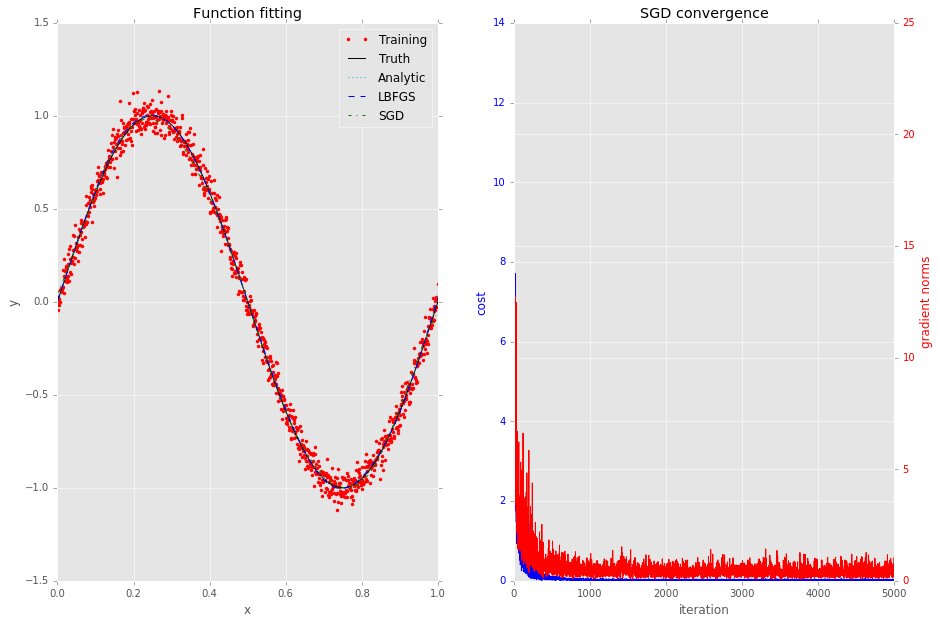

In [8]:
fig = pl.figure(figsize=(15, 10))
ax = fig.add_subplot(121)

# truth
pl.plot(X, Y, 'r.', Xs, Yt, 'k-')

# exact weights
pl.plot(Xs, Ys, 'c:')
pl.plot(Xs, Ys_grad, 'b--')
pl.plot(Xs, Ys_sgd, 'g-.')
pl.title('Function fitting')
pl.xlabel('x')
pl.ylabel('y')
pl.legend(['Training', 'Truth', 'Analytic', 'LBFGS', 'SGD'])

ax = fig.add_subplot(122)
pl.xlabel('iteration')

pl.title('SGD convergence')
ax.plot(range(len(costs)), costs, 'b')
ax.set_ylabel('cost', color='b')

for t in ax.get_yticklabels():
    t.set_color('b')

ax2 = ax.twinx()
ax2.plot(range(len(gnorms)), gnorms, 'r')
ax2.set_ylabel('gradient norms', color='r')
for t in ax2.get_yticklabels():
    t.set_color('r')

pl.show()


### Error

In [9]:
print("Analytic SMSE: {}".format(smse(Yt, Ys)))
print("Optimiser SMSE: {}".format(smse(Yt, Ys_grad)))
print("SGD SMSE: {}".format(smse(Yt, Ys_sgd)))


Analytic SMSE: 0.0001340130940667547
Optimiser SMSE: 0.0001130313529762257
SGD SMSE: 0.0006739291551022906
